In [23]:
%matplotlib inline

import numpy
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt

In [24]:
# A simplified Ca atom

ca_ionisation = units.Quantity([0.98,2.88], unit='aJ')
ca_levels = units.Quantity([[0, 0.301, 0.302, 0.303],
                           [0, 0.271, 0.272, 0.500],
                           [0, 4.404, 4.050, 4.070]], unit='aJ') #energylevels, three levels and four states(?)
ca_weights = units.Quantity([[1,1,3,5],
                            [2,4,6,2],
                            [1,1,3,5]], unit=None) #statistical weigth of each level

In [25]:
temp = 5000 * units.K

In [26]:
partition_function = numpy.sum(ca_weights * numpy.exp(-ca_levels / (constants.k_B * temp)), axis=1)
partition_function

<Quantity [1.11259945, 2.1970132 , 1.        ]>

In [27]:
boltzman_pop = (ca_weights / partition_function[:, numpy.newaxis]) * numpy.exp(-ca_levels / (constants.k_B * temp))
boltzman_pop #80% er på grunn-nivå/ground state, 2% er på første exited, 6% på andre, og så 10% på tredje exited.

<Quantity [[8.98796059e-01, 1.14820840e-02, 3.39508623e-02,
            5.57709952e-02],
           [9.10326801e-01, 3.59187994e-02, 5.31033484e-02,
            6.51051286e-04],
           [1.00000000e+00, 1.96658453e-28, 9.95190039e-26,
            1.24145644e-25]]>

In [28]:
electron_pressure = units.Quantity(100, unit='Pa')
electron_density = electron_pressure / (constants.k_B * temp)

saha_const = ((2*numpy.pi * constants.m_e * constants.k_B * temp)/(constants.h**2))**(3/2) #noramlization factor at front

pop_stage = numpy.ones_like(partition_function)
pop_stage[1:] = (1 / electron_density * 2 * partition_function[1:] / partition_function[:-1] * saha_const * numpy.exp(-ca_ionisation / (constants.k_B * temp)))

pop_stage[1:]*= pop_stage[:-1]
pop_stage[:-1]

saha_pop = pop_stage / pop_stage.sum()
saha_pop



<Quantity [3.86016257e-01, 6.13983743e-01, 2.50708796e-13]>

In [38]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, numpy.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature[numpy.newaxis, numpy.newaxis]
        return numpy.nansum(self.g[...,numpy.newaxis] * numpy.exp(-self.chi[...,numpy.newaxis]/ constants.k_B/temp),axis=1) #newaxis adds a dimension.
    
    def compute_excitation(self, temperature):
        pfunc = self.compute_partition_function(temperature) #partition func
        # Reshape the arrays
        temp = temperature[numpy.newaxis, numpy.newaxis]
        g_ratio = self.g[...,numpy.newaxis] / pfunc[:,numpy.newaxis]
        chi = self.chi[...,numpy.newaxis]
        return g_ratio * numpy.exp(-chi / (constants.k_B * temp))
    
    def compute_ionisation(self, temperature, electron_pressure):
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2*numpy.pi * constants.m_e * constants.k_B * temperature)/(constants.h**2))**(3/2)
        nstage = numpy.zeros_like(partition_function) / units.m **3
        nstage[0] = 1. / units.m**3
        
        for r in range(self.n_stages - 1):
            nstage[r+1] = (nstage[r] / electron_density * 2 * saha_const * \
                         partition_function[r+1] / partition_function[r] * \
                         numpy.exp(-self.chi_ion[r+1, numpy.newaxis] / (constants.k_B * temperature[numpy.newaxis]))) 
            
        return nstage / numpy.nansum(nstage,axis=0)
    
    def compute_population(self,temperature, electron_pressure):
        
        return (self.compute_excitation(temperature)*self.compute_ionisation(temperature, electron_pressure)[:,numpy.newaxis])
    
    def plot_payne(self,temperature, electron_pressure):
        pops = self.compute_population(temperature, electron_pressure)
        fig,ax = plt.subplots()
        ax.plot(numpy.tile(temp, (self.n_stages,1)).T, pops[:,0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:,1].T, 'r--')
        if n_levels > 2:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:,2].T, 'k:')
            
        ax.set_yscale('log')
        ax.set_ylim(1e-4, 1.1)
        ax.set_xlabel("Temperature(K)")
        ax.set_ylabel("Populations")
        

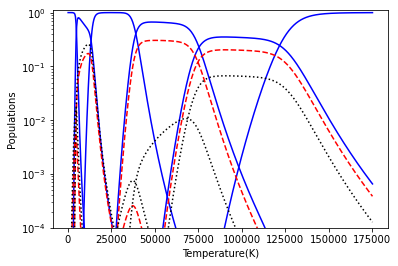

In [39]:
my_atom = Atom("Ca_atom.txt")
#temp = 5000 * units.K
temp = numpy.linspace(100,175000,500) * units.K
#my_atom.compute_partition_function(temp)
#my_atom.compute_excitation(temp)

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)

In [46]:
new_atom = Atom("Ca_atom.txt")
new_atom.compute_partition_function(5000.0 * units.K)  #partition func for 5000 K

<Quantity [[1.16887507],
           [2.19889057],
           [1.        ],
           [4.81535504],
           [6.91357026],
           [2.        ]]>

In [47]:
new_atom.compute_partition_function(10000.0 * units.K) #partition func for 10000 K

<Quantity [[3.45978297],
           [3.55231088],
           [1.        ],
           [5.27699259],
           [8.08152705],
           [2.        ]]>

In [48]:
new_atom.compute_partition_function(20000.0 * units.K) #partition func for 20000 K

<Quantity [[13.62724264],
           [ 6.70523086],
           [ 1.00001079],
           [ 5.5981684 ],
           [ 9.64653685],
           [ 2.        ]]>

What can you say about the temperature dependence of  𝑈𝑟 ?

Kan se ut i fra uttrykket at når T øker, så blir exp uttrykket et større tall (siden det er opphøyd i -), som vi kan se stemmer med verdiene vi får.
Partisjonsfunk for hvert steg øker med temperaturen.

The partition function for each stage increases with the temperature, except the upper stage (?). From the expression, we observe that when T increases, the exponential increases as well, and as a result the partition function for each stage increases with the temperature.

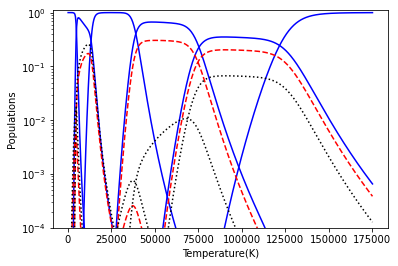

In [51]:
my_atom = Atom("Ca_atom.txt")
temp = numpy.linspace(100,175000,500) * units.K

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)

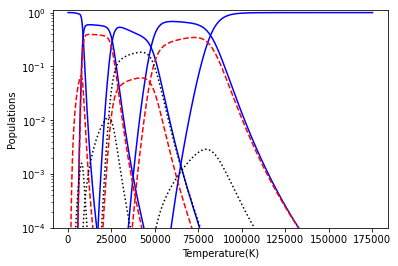

In [52]:
my_atom = Atom("C_atom.txt")
temp = numpy.linspace(100,175000,500) * units.K

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)

In [53]:
my_atom = Atom("He_atom.txt")
temp = numpy.linspace(100,175000,500) * units.K

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)

In [54]:
my_atom = Atom("H_atom.txt")
temp = numpy.linspace(100,175000,500) * units.K

e_press = 100 * units.Pa
my_atom.plot_payne(temp,e_press)